# 글자 단위 RNN(Char RNN)

* 지금까지 배운 RNN은 전부 입력과 출력의 단위가 단어 벡터였다.
* 하지만 입출력의 단위를 word-level에서 character-level로 변경하여 RNN을 구현할 수 있다.

## 글자 단위 RNN 언어 모델(Char RNNLM)

* '이상한 나라의 엘리스' 소설을 이용해 구현

### 1) 데이터에 대한 이해와 전처리

In [10]:
import numpy as np
#import urllib.request
from tensorflow.keras.utils import to_categorical

In [11]:
file_path = '/home/jaehoon/Desktop/AI_Study/11-0/11-0.txt'

with open(file_path, 'rb') as file:
    lines = list()

    for line in file:
        line = line.strip()
        line = line.lower()
        line = line.decode('ascii', 'ignore')
        
        if len(line) > 0: lines.append(line)

In [12]:
lines[:5]

['the project gutenberg ebook of alices adventures in wonderland, by lewis carroll',
 'this ebook is for the use of anyone anywhere in the united states and',
 'most other parts of the world at no cost and with almost no restrictions',
 'whatsoever. you may copy it, give it away or re-use it under the terms',
 'of the project gutenberg license included with this ebook or online at']

In [14]:
# list의 각 원소는 문자열로 구성되어 있고 의미있는 문장 토큰화가 이루어지지 않음
# 하나의 문자열로 통합
text = ''.join(lines)
print(f'문자열의 총 길이: {len(text)}')
print(text[:200])

문자열의 총 길이: 156675
the project gutenberg ebook of alices adventures in wonderland, by lewis carrollthis ebook is for the use of anyone anywhere in the united states andmost other parts of the world at no cost and with a


In [19]:
# 단어 집합이 아닌 글자 집합을 생성
char_vocab = sorted(list(set(text)))
vocab_size = len(char_vocab)
print(f'글자 집합의 크기: {vocab_size} \n')

char2Idx = { c:i for i,c in enumerate(char_vocab) }
print(f'char2Idx: \n {char2Idx} \n\n')

idx2Char = { i:c for i,c in enumerate(char_vocab)}
print(f'idx2Char: \n {idx2Char}')

글자 집합의 크기: 56 

char2Idx: 
 {' ': 0, '!': 1, '"': 2, '#': 3, '$': 4, '%': 5, "'": 6, '(': 7, ')': 8, '*': 9, ',': 10, '-': 11, '.': 12, '/': 13, '0': 14, '1': 15, '2': 16, '3': 17, '4': 18, '5': 19, '6': 20, '7': 21, '8': 22, '9': 23, ':': 24, ';': 25, '?': 26, '[': 27, ']': 28, '_': 29, 'a': 30, 'b': 31, 'c': 32, 'd': 33, 'e': 34, 'f': 35, 'g': 36, 'h': 37, 'i': 38, 'j': 39, 'k': 40, 'l': 41, 'm': 42, 'n': 43, 'o': 44, 'p': 45, 'q': 46, 'r': 47, 's': 48, 't': 49, 'u': 50, 'v': 51, 'w': 52, 'x': 53, 'y': 54, 'z': 55} 


idx2Char: 
 {0: ' ', 1: '!', 2: '"', 3: '#', 4: '$', 5: '%', 6: "'", 7: '(', 8: ')', 9: '*', 10: ',', 11: '-', 12: '.', 13: '/', 14: '0', 15: '1', 16: '2', 17: '3', 18: '4', 19: '5', 20: '6', 21: '7', 22: '8', 23: '9', 24: ':', 25: ';', 26: '?', 27: '[', 28: ']', 29: '_', 30: 'a', 31: 'b', 32: 'c', 33: 'd', 34: 'e', 35: 'f', 36: 'g', 37: 'h', 38: 'i', 39: 'j', 40: 'k', 41: 'l', 42: 'm', 43: 'n', 44: 'o', 45: 'p', 46: 'q', 47: 'r', 48: 's', 49: 't', 50: 'u', 51: 'v', 52:

In [20]:
# 문장의 길이를 60으로 제
seq_len = 60

# text의 문자열을 60등분
n_samples = int(np.floor((len(text)-1) / seq_len))
print(f'문장 샘플의 수: {n_samples}')

문장 샘플의 수: 2611


In [22]:
train_X = []
train_y = []

for i in range(n_samples):
    X_sample = text[i * seq_len: (i + 1) * seq_len]
    #print(f'X_sample: {X_sample}')
    X_encoded = [ char2Idx[ch] for ch in X_sample ]
    train_X.append(X_encoded)
    
    y_sample = text[i * seq_len + 1: (i+1) * seq_len + 1]
    y_encoded = [ char2Idx[ch] for ch in y_sample ]
    train_y.append(y_encoded)

In [29]:
print(train_X[0], '\n')
print(train_y[0])

print(train_X[0][1:] == train_y[0][:-1])

[49, 37, 34, 0, 45, 47, 44, 39, 34, 32, 49, 0, 36, 50, 49, 34, 43, 31, 34, 47, 36, 0, 34, 31, 44, 44, 40, 0, 44, 35, 0, 30, 41, 38, 32, 34, 48, 0, 30, 33, 51, 34, 43, 49, 50, 47, 34, 48, 0, 38, 43, 0, 52, 44, 43, 33, 34, 47, 41, 30] 

[37, 34, 0, 45, 47, 44, 39, 34, 32, 49, 0, 36, 50, 49, 34, 43, 31, 34, 47, 36, 0, 34, 31, 44, 44, 40, 0, 44, 35, 0, 30, 41, 38, 32, 34, 48, 0, 30, 33, 51, 34, 43, 49, 50, 47, 34, 48, 0, 38, 43, 0, 52, 44, 43, 33, 34, 47, 41, 30, 43]
True


In [30]:
# train_X와 train_y 에 대한 one-hot encoding
# 글자 단위 RNN에서는 입력 시퀀스에 대해서 워드 임베딩을 하지 않는다.
# 즉, embedding layer를 사용하지 않을 것임

train_X = to_categorical(train_X)
train_y = to_categorical(train_y)

print(f'train_X의 크기: {train_X.shape}')
print(f'train_y의 크기: {train_y.shape}')

train_X의 크기: (2611, 60, 56)
train_y의 크기: (2611, 60, 56)


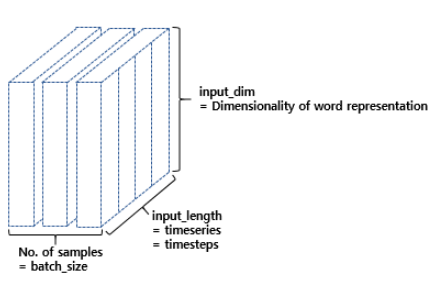

* 샘플의 수: 2611 개
* 입력 시퀀스의 길이: 60
* 각 벡터의 차원: 56

### 2) 모델 설계하기

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed

In [61]:
model = Sequential()
model.add(LSTM(256, input_shape=(None,train_X.shape[-1]), return_sequences=True))
model.add(LSTM(256, return_sequences=True))
model.add(TimeDistributed(Dense(vocab_size, activation='relu')))

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.fit(train_X, train_y, epochs=80, verbose=2)

model.summary()

Epoch 1/2
82/82 - 17s - loss: 3.3347 - accuracy: 0.1569
Epoch 2/2
82/82 - 15s - loss: 3.1149 - accuracy: 0.1728
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, None, 256)         320512    
_________________________________________________________________
lstm_9 (LSTM)                (None, None, 256)         525312    
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 56)          14392     
Total params: 860,216
Trainable params: 860,216
Non-trainable params: 0
_________________________________________________________________


In [62]:
def sentence_generation(model, length):
    # 글자에 대한 랜덤 인덱스 생성
    rand_idx = [np.random.randint(vocab_size)]
    
    #idx2Char랜덤 인덱스로부터 글자 생성
    y_char = [idx2Char[rand_idx[-1]]]
    print(f'{rand_idx[-1]}번 글자, {y_char}로 예측을 시작')
    
    # (1, length, 56) 크기의 X 생성 (LSTM의 입력 시퀀스)
    X = np.zeros((1, length, vocab_size))
    
    for idx in range(length):
        # X[0][idx][예측한 글자의 인덱스] = 1
        # 즉, 예측 글자를 다음 입력 시퀀스에 추가
        X[0][idx][rand_idx[-1]] = 1
        
        print(idx2Char[rand_idx[-1]], end="")
        rand_idx = np.argmax(model.predict(X[:, :idx+1, :])[0], 1)
        y_char.append(idx2Char[rand_idx[-1]])
    return ('').join(y_char)

In [63]:
sentence_generation(model, 100)

47번 글자, ['r']로 예측을 시작
r                                                                                                   

'r                                                                                                    '

## 2. Char RNN으로 텍스트 생성하기

* many-to-one 구조의 RNN을 글자 단위로 학습시키고, 텍스트를 생성

### 1) 데이터의 이해와 전처리

In [16]:
import numpy as np
from tensorflow.keras.utils import to_categorical

In [17]:
text='''
I get on with life as a programmer,
I like to contemplate beer.
But when I start to daydream,
My mind turns straight to wine.

Do I love wine more than beer?

I like to use words about beer.
But when I stop my talking,
My mind turns straight to wine.

I hate bugs and errors.
But I just think back to wine,
And I'm happy once again.

I like to hang out with programming and deep learning.
But when left alone,
My mind turns straight to wine.
'''

In [18]:
tokens = text.split()
text = ' '.join(tokens)
print(text)

I get on with life as a programmer, I like to contemplate beer. But when I start to daydream, My mind turns straight to wine. Do I love wine more than beer? I like to use words about beer. But when I stop my talking, My mind turns straight to wine. I hate bugs and errors. But I just think back to wine, And I'm happy once again. I like to hang out with programming and deep learning. But when left alone, My mind turns straight to wine.


In [29]:
char_vocab = sorted(list(set(text)))
vocab_size = len(char_vocab)
print(char_vocab)
print(len(char_vocab))

[' ', "'", ',', '.', '?', 'A', 'B', 'D', 'I', 'M', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'y']
33


In [30]:
char_to_index = {c:i for i, c in enumerate(char_vocab) }
print(char_to_index)

{' ': 0, "'": 1, ',': 2, '.': 3, '?': 4, 'A': 5, 'B': 6, 'D': 7, 'I': 8, 'M': 9, 'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15, 'g': 16, 'h': 17, 'i': 18, 'j': 19, 'k': 20, 'l': 21, 'm': 22, 'n': 23, 'o': 24, 'p': 25, 'r': 26, 's': 27, 't': 28, 'u': 29, 'v': 30, 'w': 31, 'y': 32}


In [31]:
index_to_char = {i:c for i, c in enumerate(char_vocab)}
print(index_to_char)

{0: ' ', 1: "'", 2: ',', 3: '.', 4: '?', 5: 'A', 6: 'B', 7: 'D', 8: 'I', 9: 'M', 10: 'a', 11: 'b', 12: 'c', 13: 'd', 14: 'e', 15: 'f', 16: 'g', 17: 'h', 18: 'i', 19: 'j', 20: 'k', 21: 'l', 22: 'm', 23: 'n', 24: 'o', 25: 'p', 26: 'r', 27: 's', 28: 't', 29: 'u', 30: 'v', 31: 'w', 32: 'y'}


In [32]:
# 입력시퀀스의 길이가 11이 되도록 구성

length = 11
sequences = []
for i in range(length, len(text)):
    seq = text[i-length:i]
    sequences.append(seq)
print('총 훈련 샘플의 수 ', len(sequences))

총 훈련 샘플의 수  426


In [33]:
sequences[:10]

['I get on wi',
 ' get on wit',
 'get on with',
 'et on with ',
 't on with l',
 ' on with li',
 'on with lif',
 'n with life',
 ' with life ',
 'with life a']

In [34]:
# 정수 인코딩
X = []

for line in sequences:
    temp_X = [char_to_index[ch] for ch in line]
    X.append(temp_X)

In [35]:
for line in X[:5]:
    print(line)

[8, 0, 16, 14, 28, 0, 24, 23, 0, 31, 18]
[0, 16, 14, 28, 0, 24, 23, 0, 31, 18, 28]
[16, 14, 28, 0, 24, 23, 0, 31, 18, 28, 17]
[14, 28, 0, 24, 23, 0, 31, 18, 28, 17, 0]
[28, 0, 24, 23, 0, 31, 18, 28, 17, 0, 21]


In [36]:
sequences = np.array(X)
X = sequences[:,:-1]
y = sequences[:,-1]

In [37]:
print(y[:5])

[18 28 17  0 21]


In [38]:
temp_cate = [to_categorical(data, num_classes=vocab_size) for data in X]
X = np.array(temp_cate)
y = to_categorical(y, num_classes=vocab_size)

In [39]:
print(X.shape)
print(y.shape)

(426, 10, 33)
(426, 33)


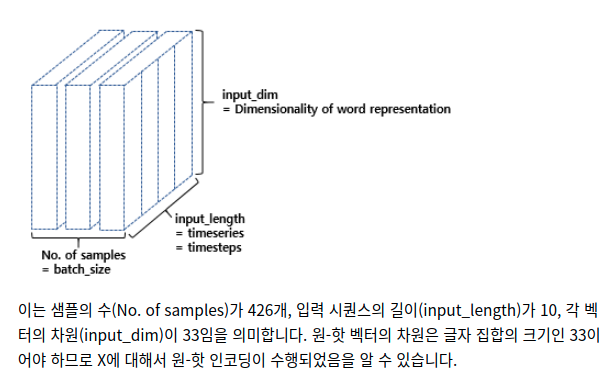

### 2) 모델 설계하기

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [41]:
model = Sequential()
model.add(LSTM(80, input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(vocab_size, activation='softmax'))

2021-08-11 18:55:43.099294: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-08-11 18:55:43.099325: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-08-11 18:55:43.099349: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jaehoon-15ZD980-GX76K): /proc/driver/nvidia/version does not exist
2021-08-11 18:55:43.099577: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [42]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, y, epochs=100, verbose=2)

2021-08-11 18:55:49.385107: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-11 18:55:49.406455: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 1999965000 Hz


Epoch 1/100
14/14 - 1s - loss: 3.4644 - accuracy: 0.1573
Epoch 2/100
14/14 - 0s - loss: 3.3141 - accuracy: 0.1972
Epoch 3/100
14/14 - 0s - loss: 3.0381 - accuracy: 0.1972
Epoch 4/100
14/14 - 0s - loss: 2.9816 - accuracy: 0.1972
Epoch 5/100
14/14 - 0s - loss: 2.9452 - accuracy: 0.1972
Epoch 6/100
14/14 - 0s - loss: 2.9237 - accuracy: 0.1972
Epoch 7/100
14/14 - 0s - loss: 2.9046 - accuracy: 0.1972
Epoch 8/100
14/14 - 0s - loss: 2.8762 - accuracy: 0.1972
Epoch 9/100
14/14 - 0s - loss: 2.8512 - accuracy: 0.1972
Epoch 10/100
14/14 - 0s - loss: 2.8185 - accuracy: 0.2019
Epoch 11/100
14/14 - 0s - loss: 2.7914 - accuracy: 0.2136
Epoch 12/100
14/14 - 0s - loss: 2.7359 - accuracy: 0.2230
Epoch 13/100
14/14 - 0s - loss: 2.7009 - accuracy: 0.2089
Epoch 14/100
14/14 - 0s - loss: 2.6548 - accuracy: 0.2559
Epoch 15/100
14/14 - 0s - loss: 2.6205 - accuracy: 0.2488
Epoch 16/100
14/14 - 0s - loss: 2.5501 - accuracy: 0.2746
Epoch 17/100
14/14 - 0s - loss: 2.5001 - accuracy: 0.2934
Epoch 18/100
14/14 - 0s

In [43]:
def sentence_generation(model, char_to_index, seq_length, seed_text, n):
# 모델, 인덱스 정보, 문장 길이, 초기 시퀀스, 반복 횟수
    init_text = seed_text # 문장 생성에 사용할 초기 시퀀스
    sentence = ''

    for _ in range(n): # n번 반복
        encoded = [char_to_index[char] for char in seed_text] # 현재 시퀀스에 대한 정수 인코딩
        encoded = pad_sequences([encoded], maxlen=seq_length, padding='pre') # 데이터에 대한 패딩
        encoded = to_categorical(encoded, num_classes=len(char_to_index))
        result = model.predict_classes(encoded, verbose=0)
        # 입력한 X(현재 시퀀스)에 대해서 y를 예측하고 y(예측한 글자)를 result에 저장.
        for char, index in char_to_index.items(): # 만약 예측한 글자와 인덱스와 동일한 글자가 있다면
            if index == result: # 해당 글자가 예측 글자이므로 break
                break
        seed_text=seed_text + char # 현재 시퀀스 + 예측 글자를 현재 시퀀스로 변경
        sentence=sentence + char # 예측 글자를 문장에 저장
        # for문이므로 이 작업을 다시 반복

    sentence = init_text + sentence
    return sentence

In [52]:
print(sentence_generation(model, char_to_index, 10, 'I get on w', 80))

I get on with life as a programmer, I like to hang out with programming and deep learning.
